In [38]:
import pandas as pd
import spectrum_utils.spectrum as sus
import spectrum_utils.plot as sup
import matplotlib.pyplot as plt
from pyteomics import mgf

In [39]:
# Load mokapot output
file_path = "../mokapot.psms.txt"
df = pd.read_csv(file_path, sep="\t")

# Display the first few rows
print(df.head())

# Select a peptide identification for analysis
peptide_row = df.iloc[0]  # Change index as needed

# Extract key information
scan_nr = peptide_row["SpecId"].split("|")[2].split("scan=")[1]
filename = peptide_row["filename"]
peptide_sequence = peptide_row["Peptide"]
exp_mass = peptide_row["ExpMass"]
calc_mass = peptide_row["CalcMass"]

      ScanNr                                        filename  \
0  1685260.0   part_6635.193557739258_7298.712913513184.mzml   
1  1405929.0   part_5971.674201965332_6635.193557739258.mzml   
2  1778537.0   part_6635.193557739258_7298.712913513184.mzml   
3  1401197.0   part_5971.674201965332_6635.193557739258.mzml   
4   132653.0  part_1990.5580673217773_2654.077423095703.mzml   

                                             Peptide    ExpMass   CalcMass  \
0             LLPHIPADQFPAQALAC[Carbamidomethyl]ELYK  2392.8170  2394.2405   
1  TLC[Carbamidomethyl]VVQEGFPTYGGLEGGAM[Oxidatio...  2392.8170  2386.0935   
2                                  ELLSQYDFPGDDTPIVR  1963.3787  1963.9528   
3                                  ILLINPTDSDAVGNAVK  1739.2767  1738.9464   
4                   HYAHVDC[Carbamidomethyl]PGHADYVK  1765.7749  1767.7788   

   Label                                             SpecId  mokapot score  \
0   True  1685260|part_6635.193557739258_7298.7129135131...      35.

In [40]:
print(f"Analyzing Peptide: {peptide_sequence} (Exp: {exp_mass}, Calc: {calc_mass})")

# Load MGF file (change filename to match your dataset)
mgf_file = f"../LFQ_Orbitrap_AIF_Ecoli_01.mgf"  # Ensure correct MGF path
spectra = list(mgf.read(mgf_file))

Analyzing Peptide: LLPHIPADQFPAQALAC[Carbamidomethyl]ELYK (Exp: 2392.817, Calc: 2394.2405)


372061


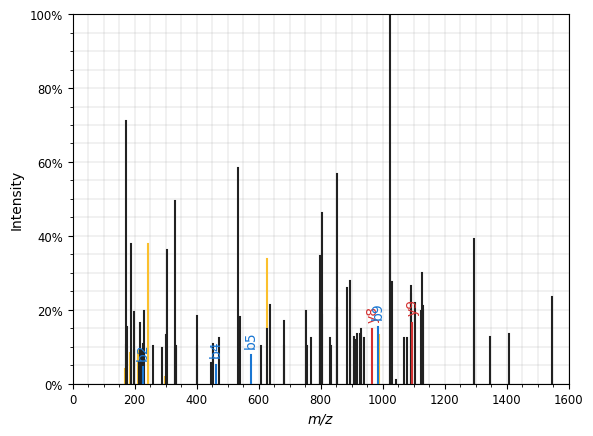

In [41]:
# Find the spectrum for the scan number
spectrum = None
print(scan_nr)
for spec in spectra:
    if str(scan_nr) in spec["params"]["title"].split("scan=")[1]:  # Check scan number match
        
        spectrum = spec
        break

if spectrum:
    # Convert to spectrum_utils format
    spec = sus.MsmsSpectrum(
        spectrum["params"]["title"],
        spectrum["params"]["pepmass"][0],  # Precursor mass
        2, #int(spectrum["params"]["charge"][0]),  # Charge state
        spectrum["m/z array"],  # m/z values
        spectrum["intensity array"],  # Intensities
    )

    # Annotate the spectrum with the peptide sequence
    spec.annotate_proforma(
        peptide_sequence,
        fragment_tol_mass=20,
        fragment_tol_mode="ppm",
        ion_types="abcxyzImpr",
    )

    # Plot the spectrum
    sup.spectrum(spec)
    plt.show()
else:
    print(f"No spectrum found for scan {scan_nr}")

  4%|▍         | 201/4969 [00:18<07:17, 10.90it/s]

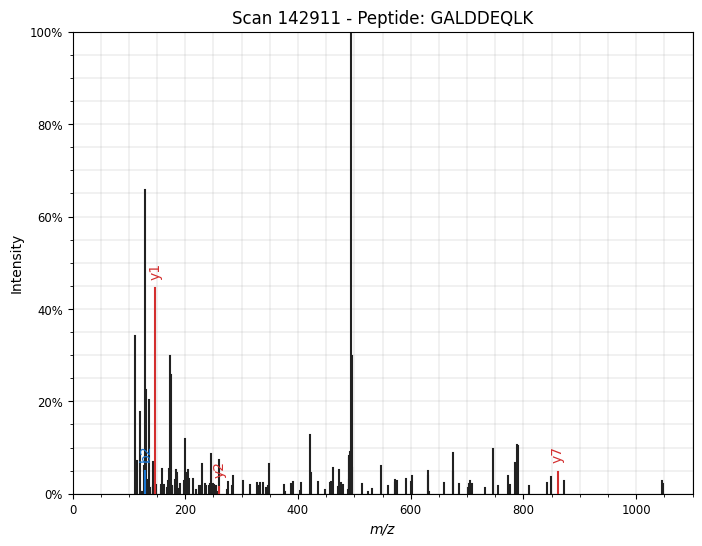

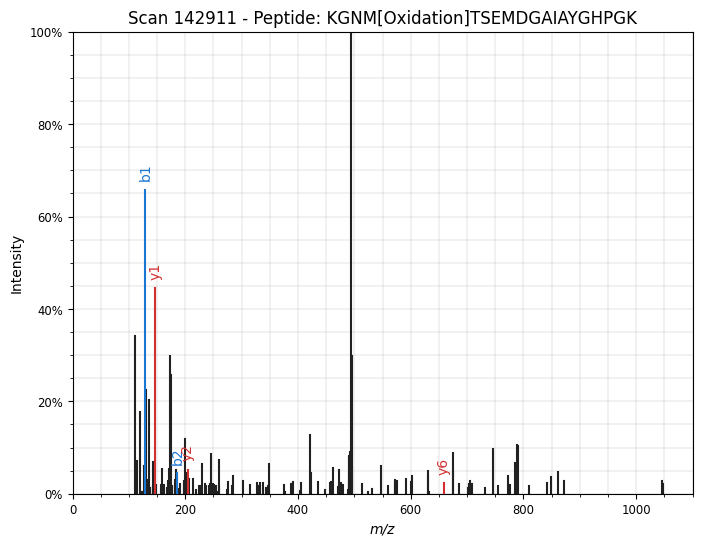

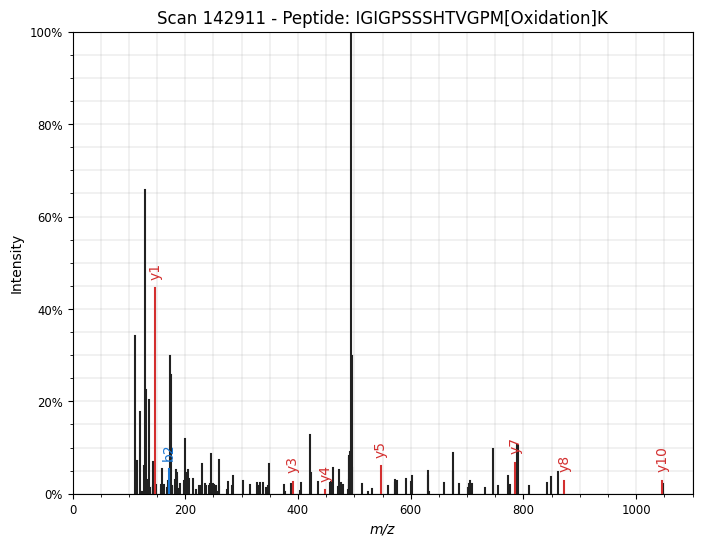

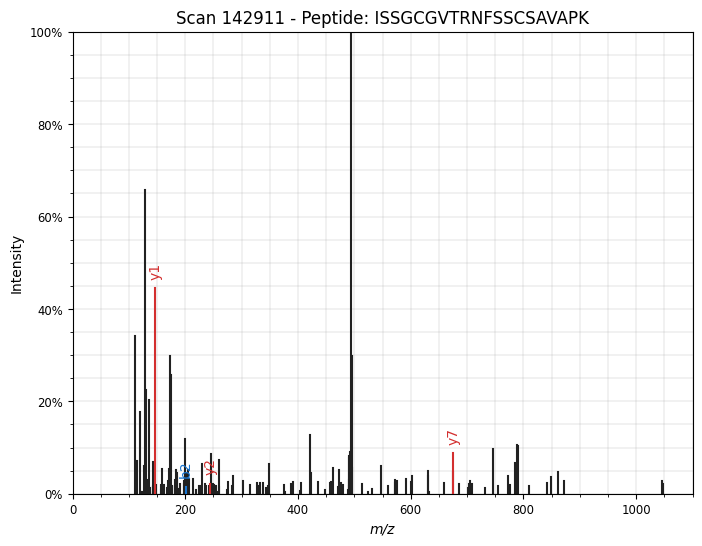

 12%|█▏        | 615/4969 [00:56<06:44, 10.76it/s]

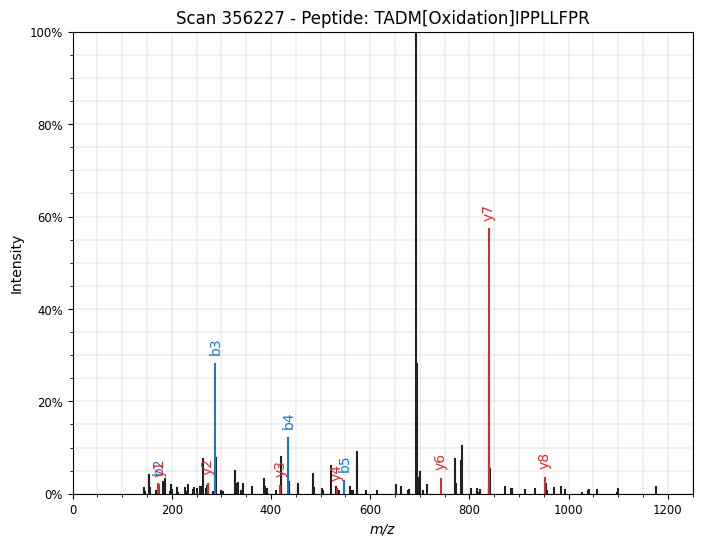

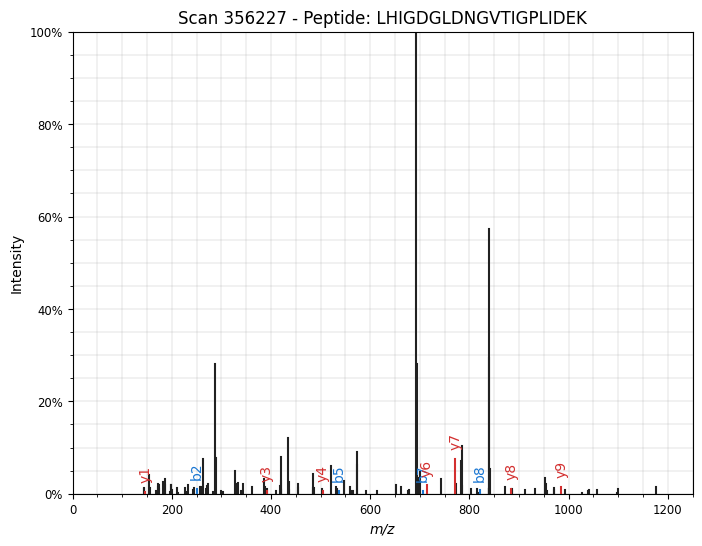

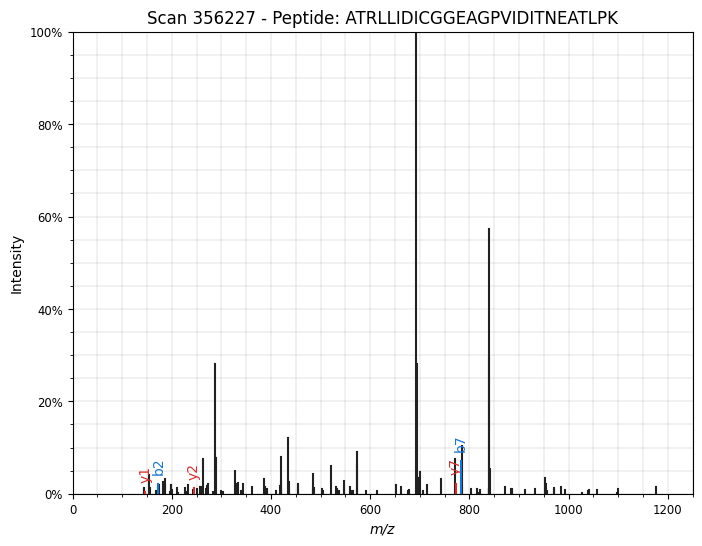

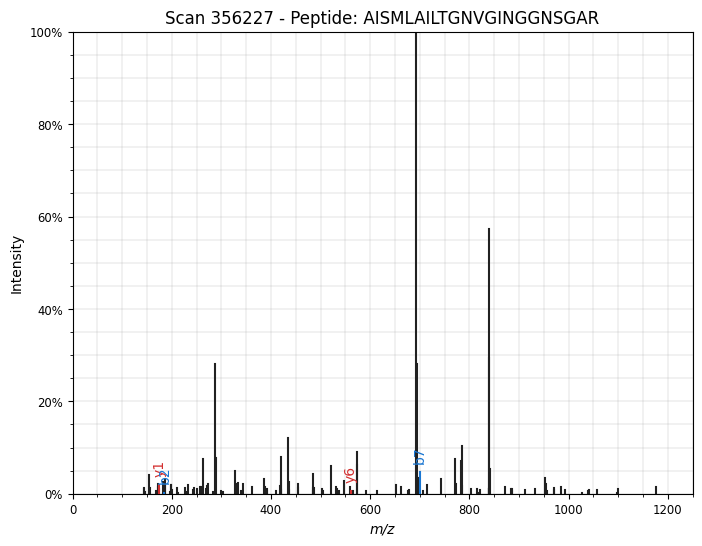

 36%|███▌      | 1796/4969 [02:43<04:46, 11.08it/s]

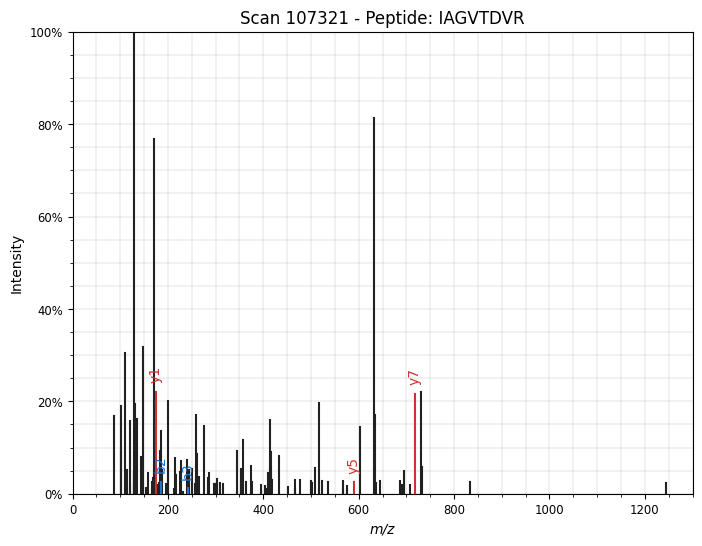

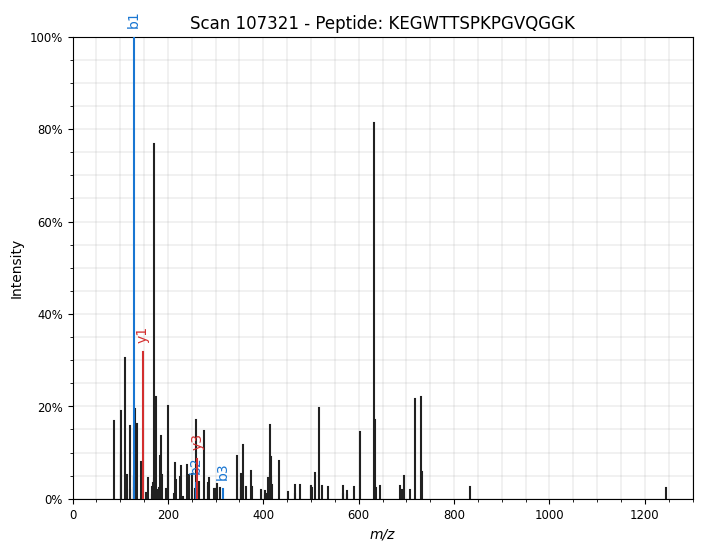

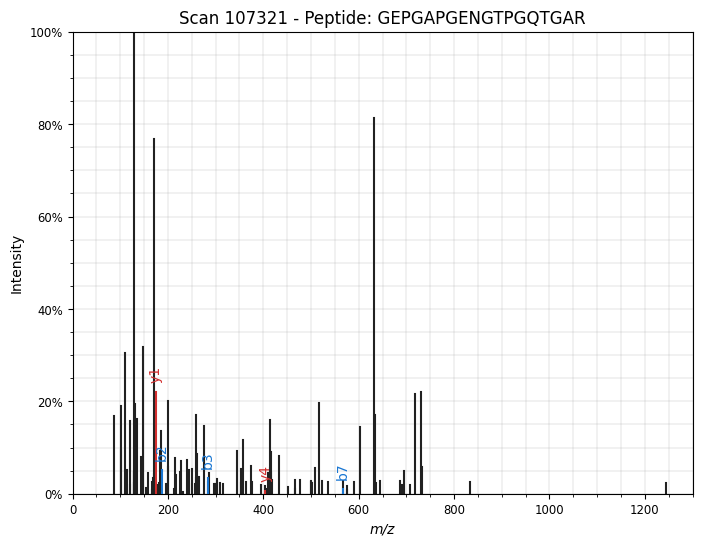

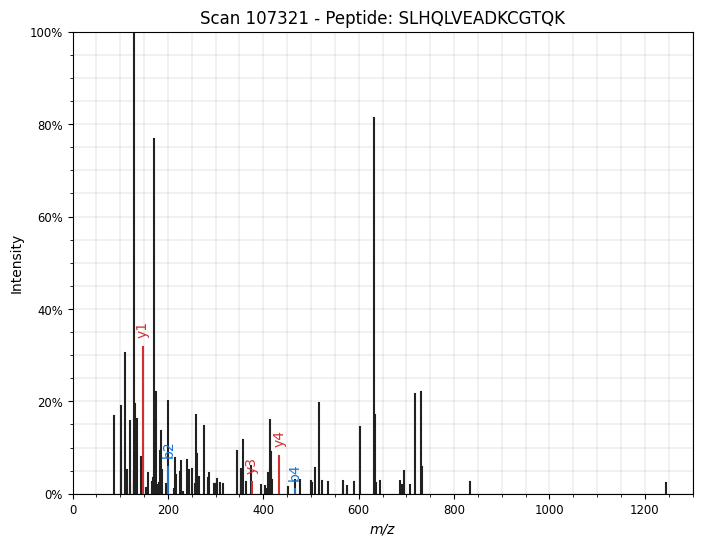

 38%|███▊      | 1891/4969 [02:53<04:47, 10.70it/s]

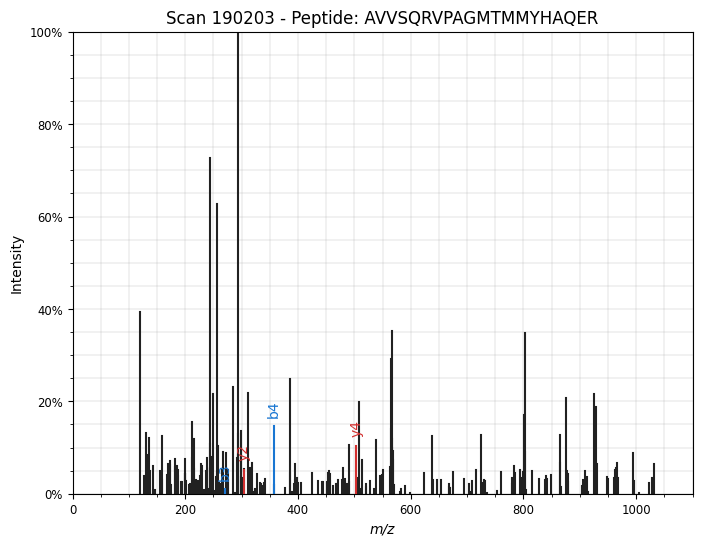

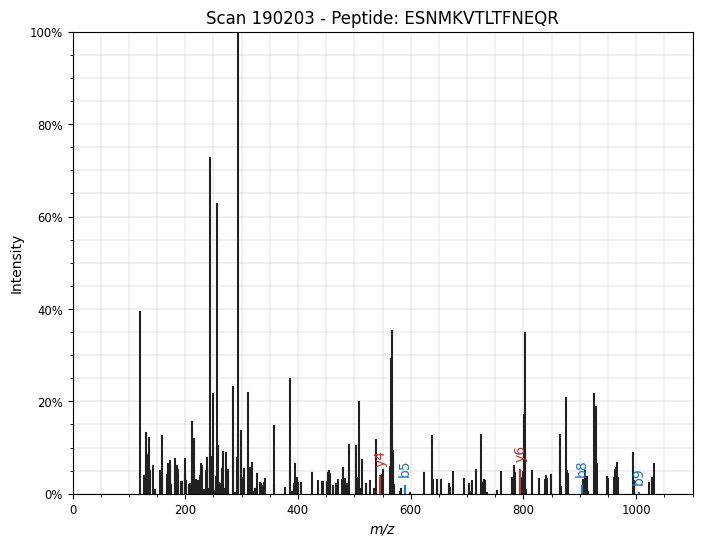

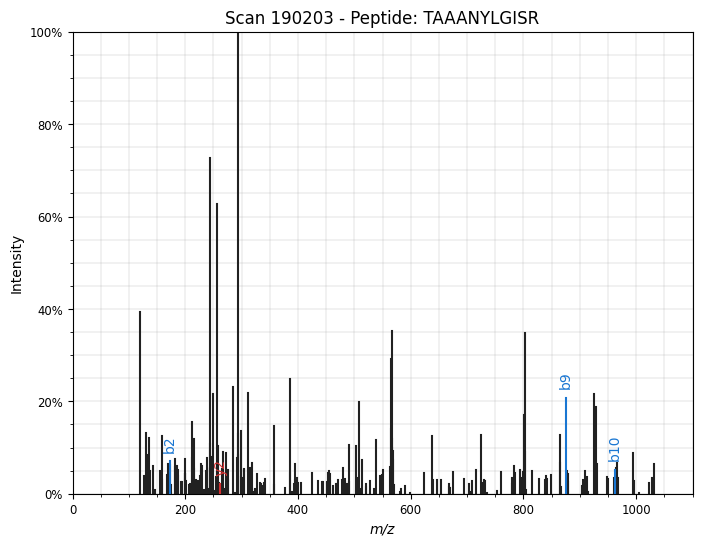

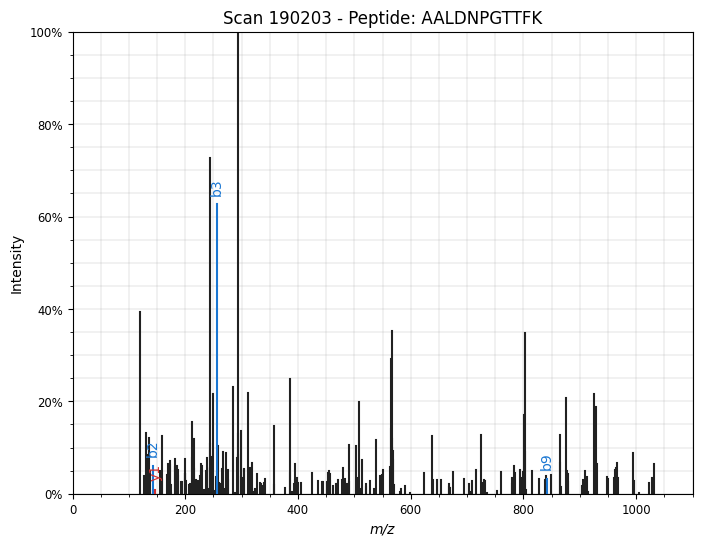

 39%|███▊      | 1919/4969 [02:56<04:55, 10.31it/s]

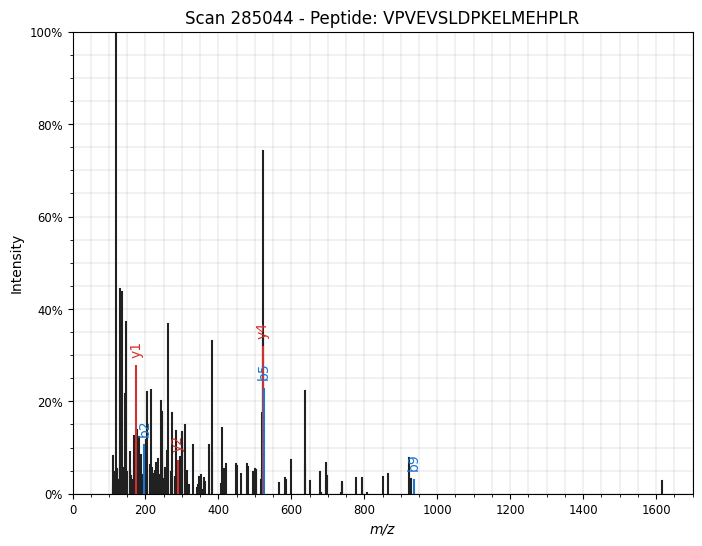

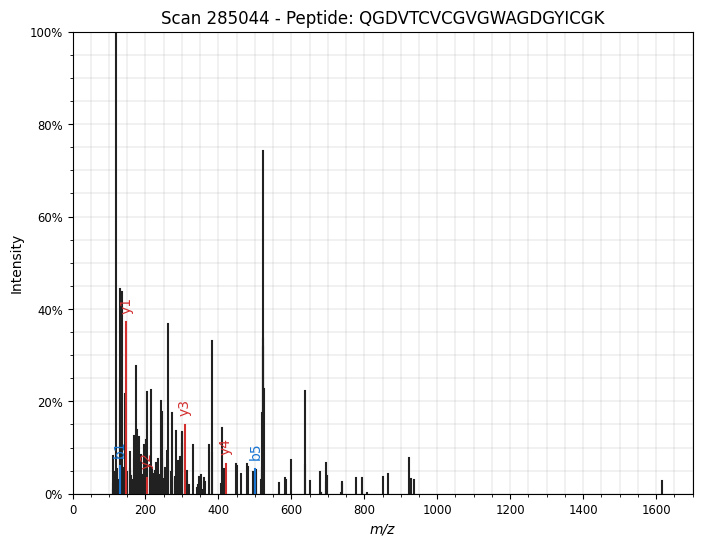

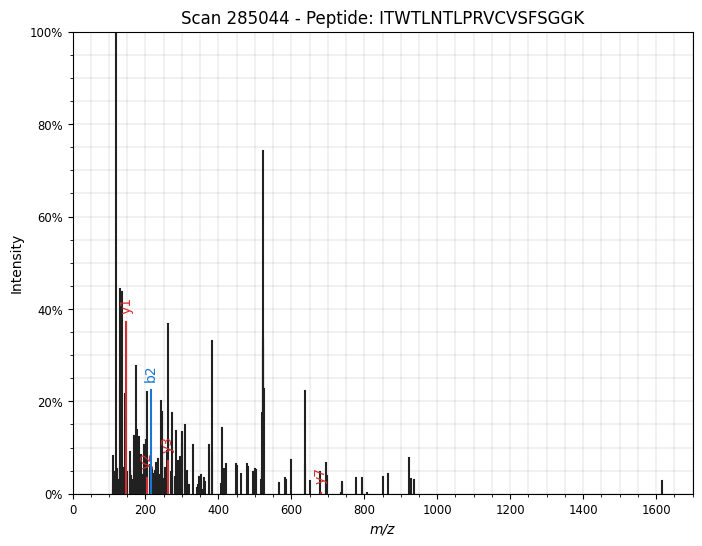

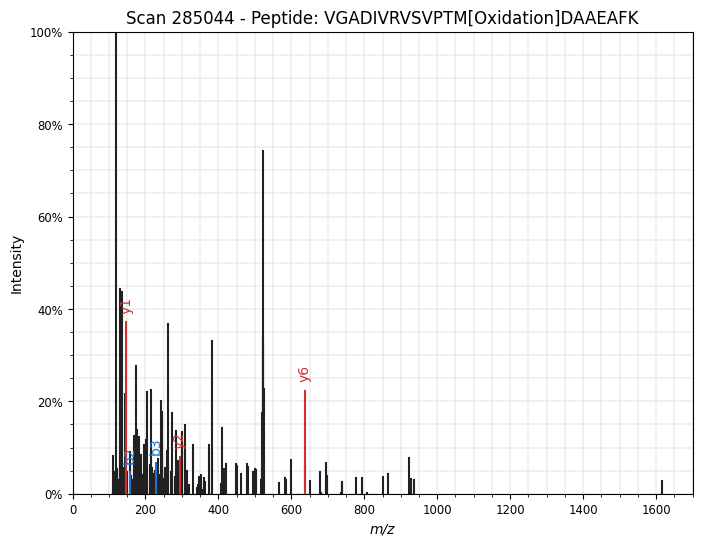

 51%|█████▏    | 2554/4969 [03:55<03:32, 11.37it/s]

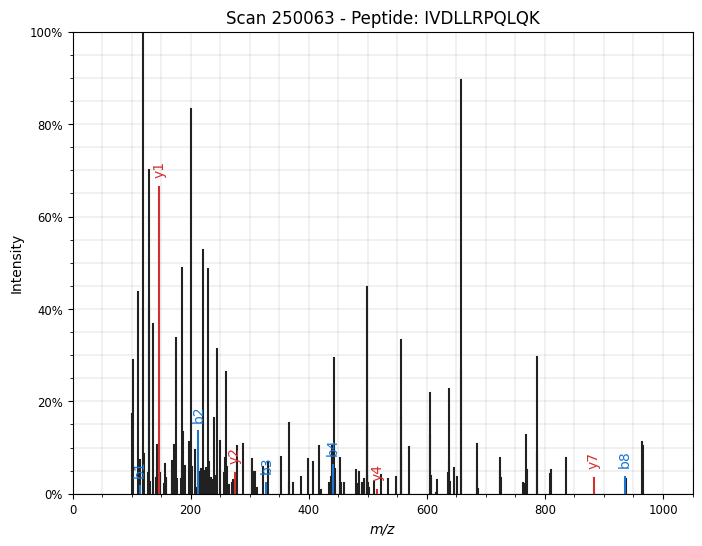

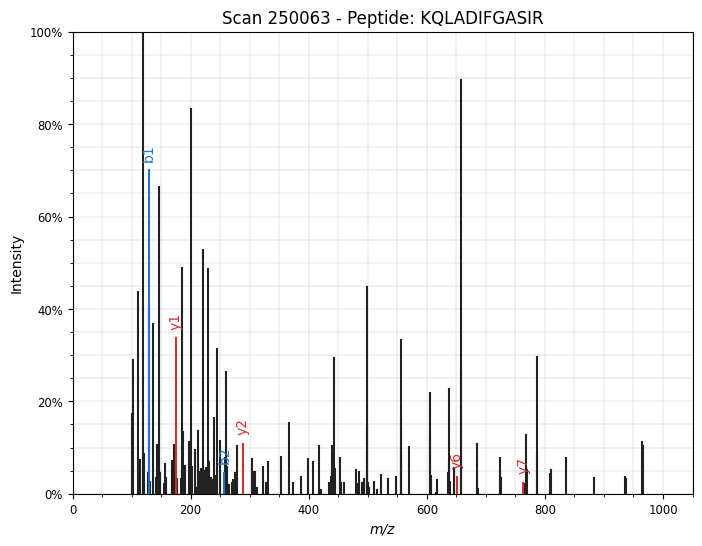

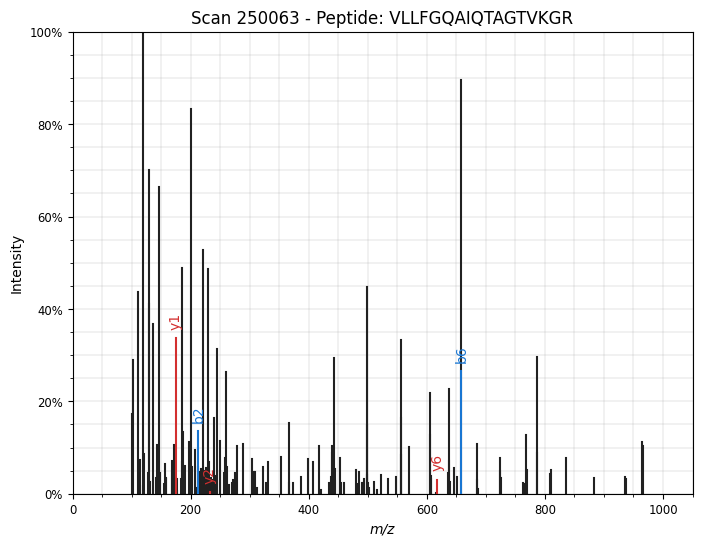

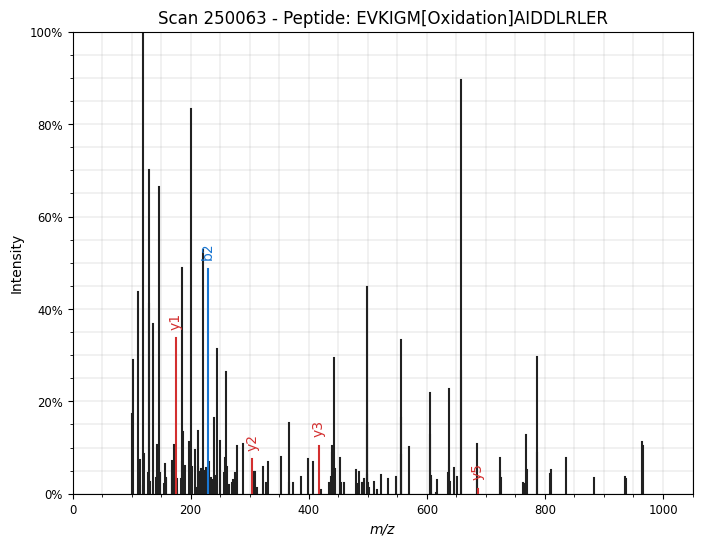

 52%|█████▏    | 2593/4969 [04:01<03:45, 10.54it/s]

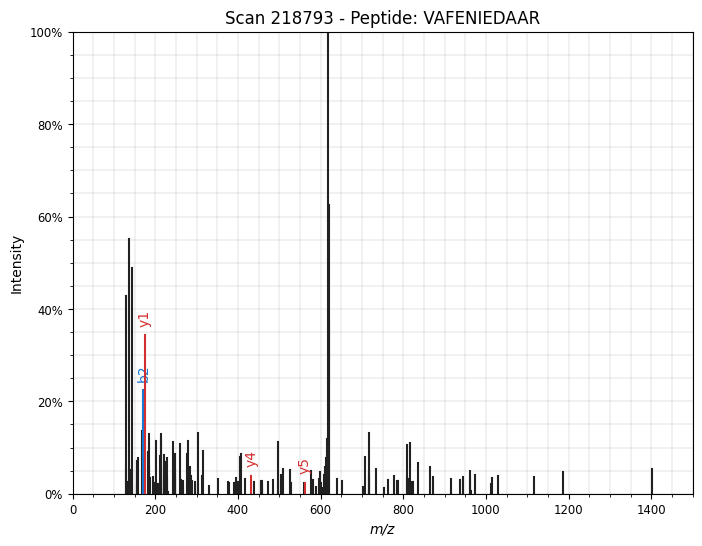

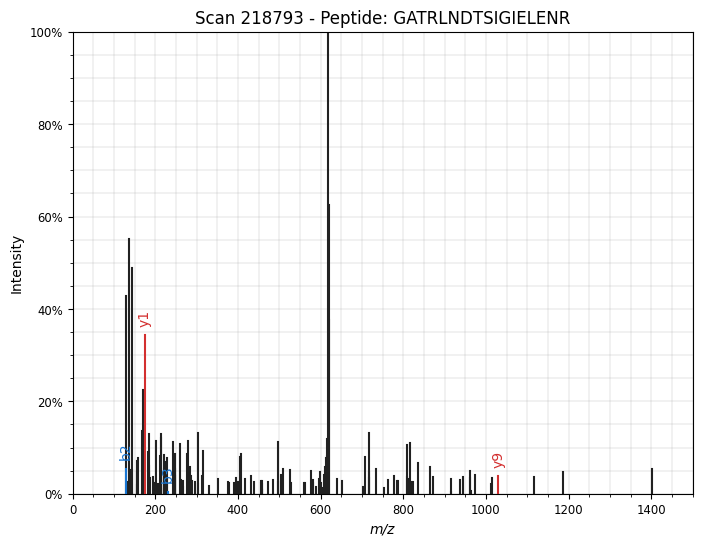

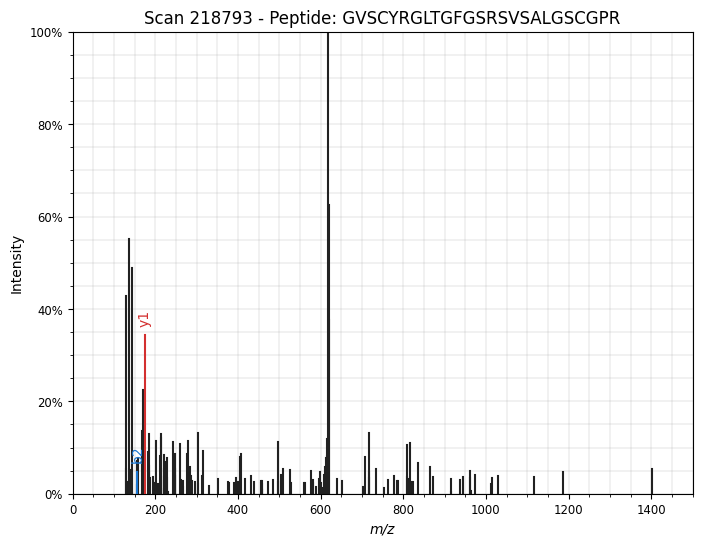

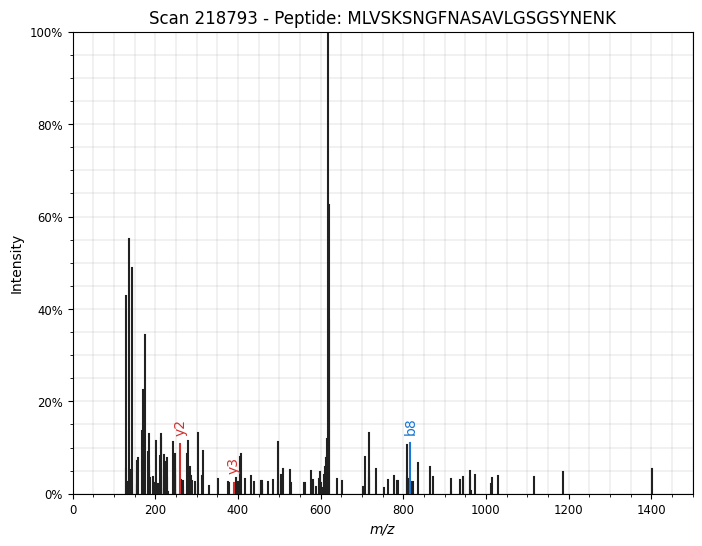

 61%|██████    | 3022/4969 [04:40<02:34, 12.63it/s]

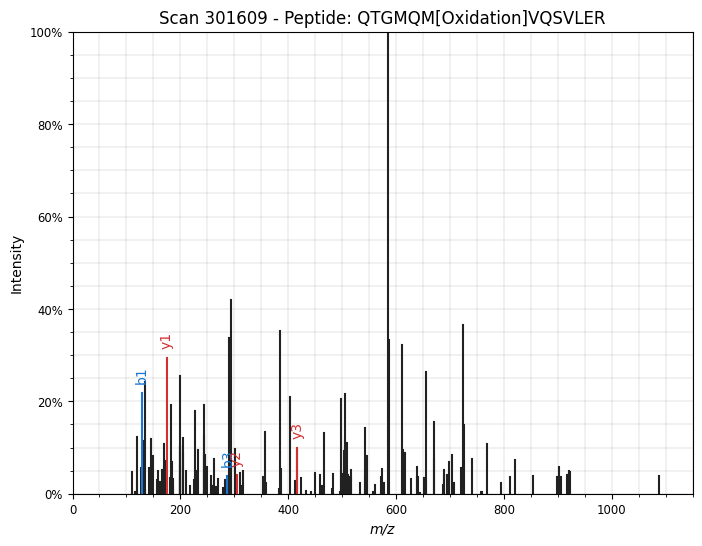

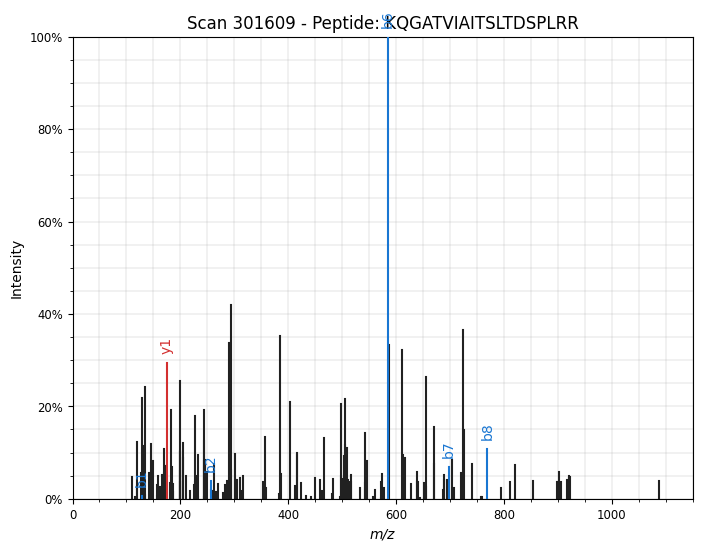

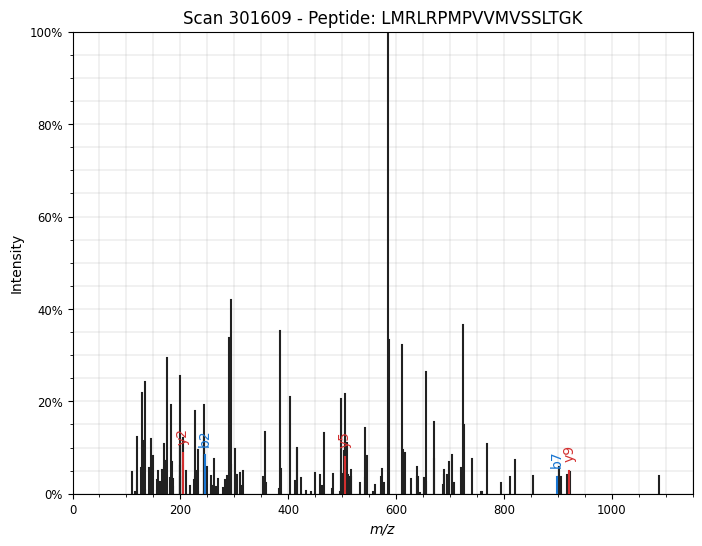

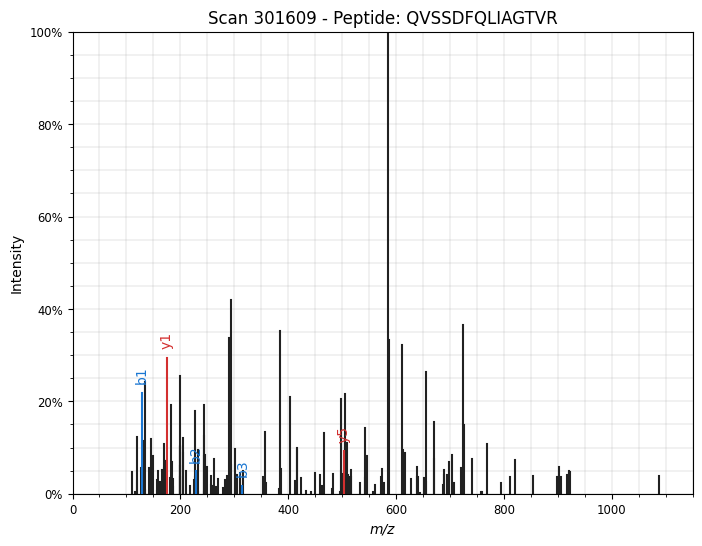

 62%|██████▏   | 3059/4969 [04:44<03:02, 10.49it/s]

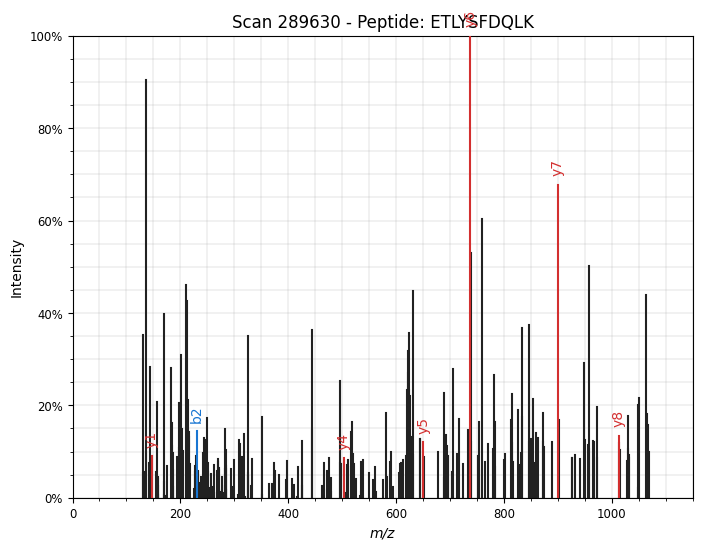

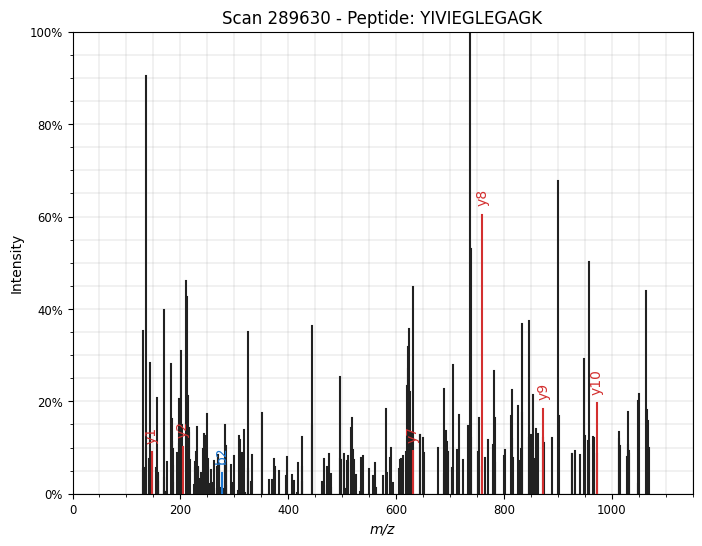

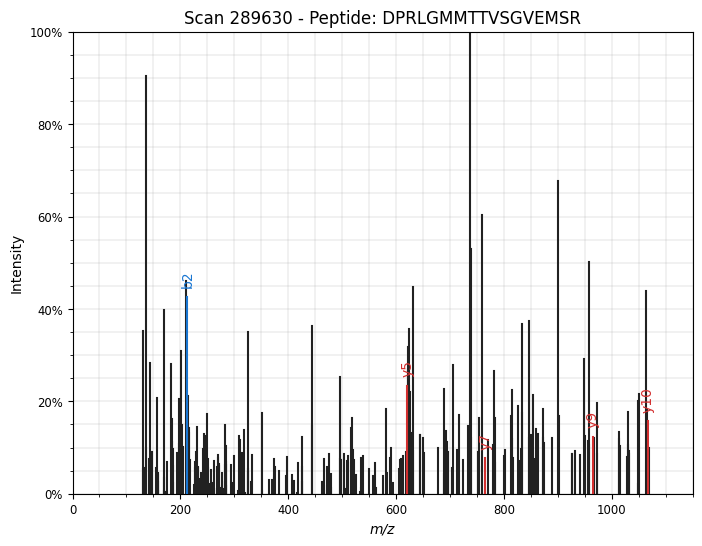

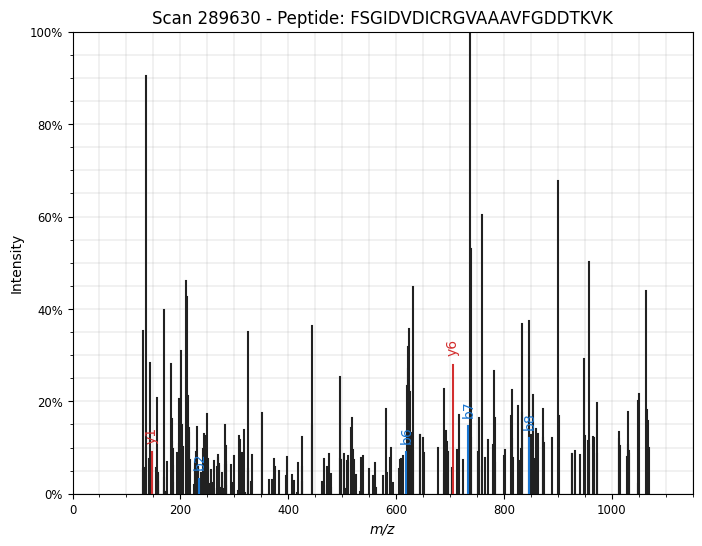

 62%|██████▏   | 3072/4969 [04:47<03:24,  9.27it/s]

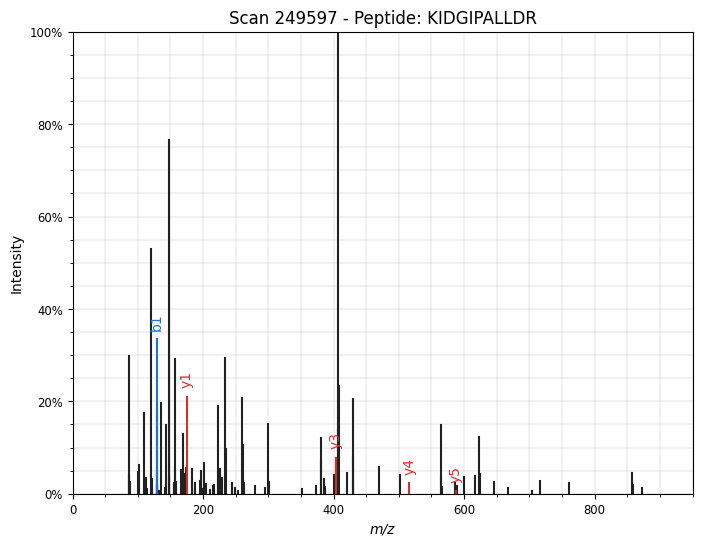

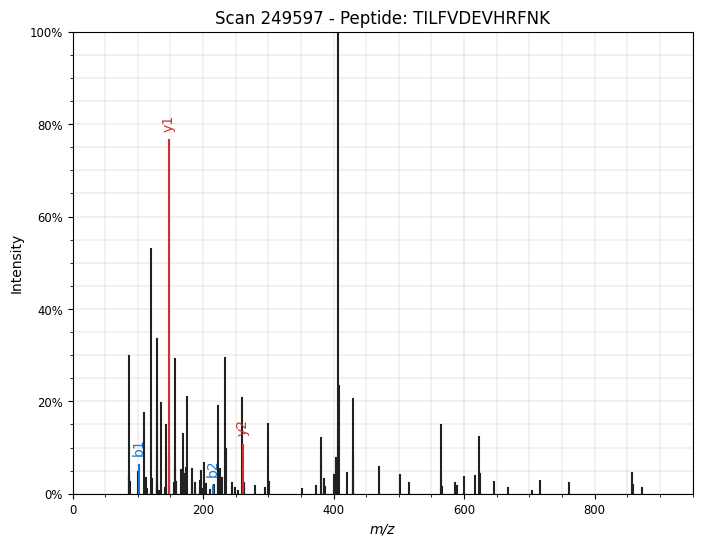

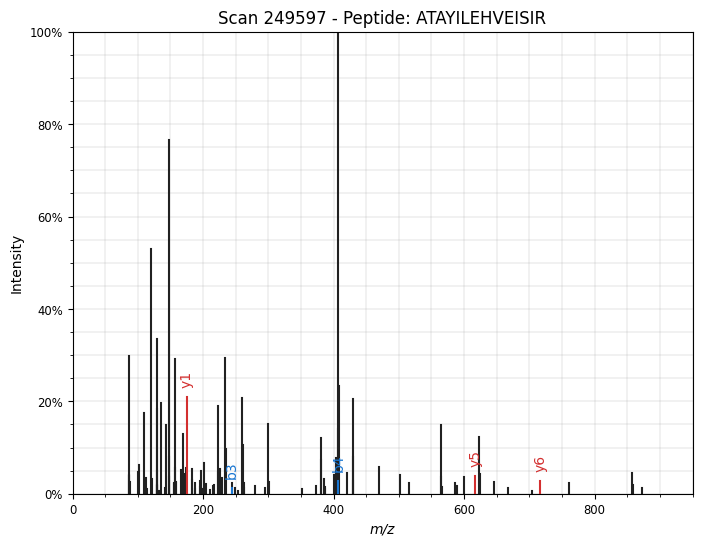

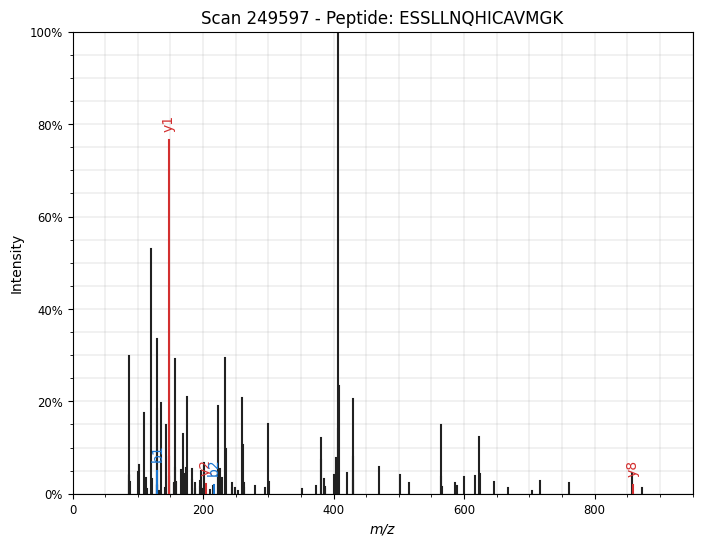

 78%|███████▊  | 3883/4969 [05:58<01:47, 10.14it/s]

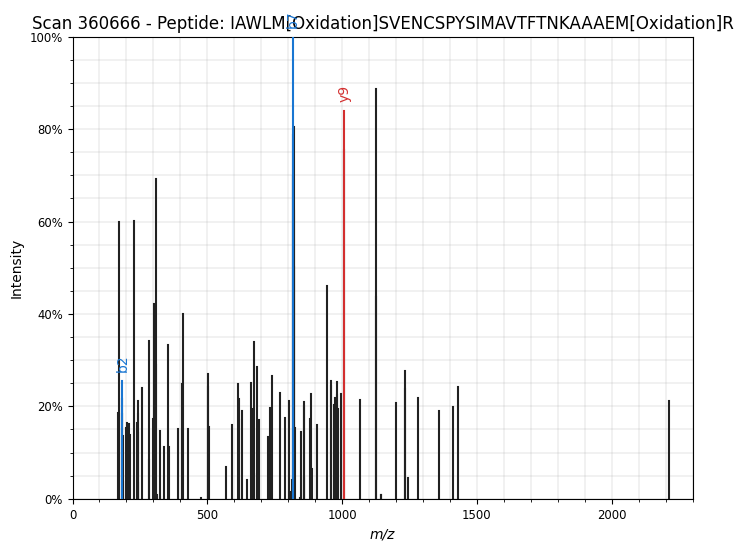

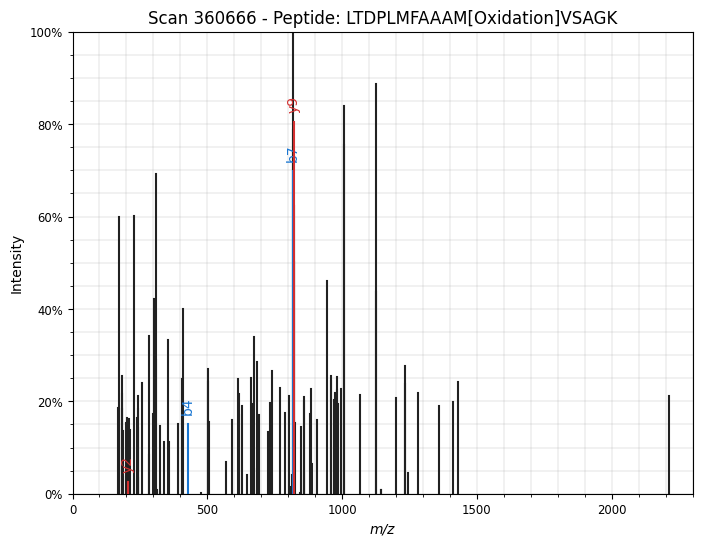

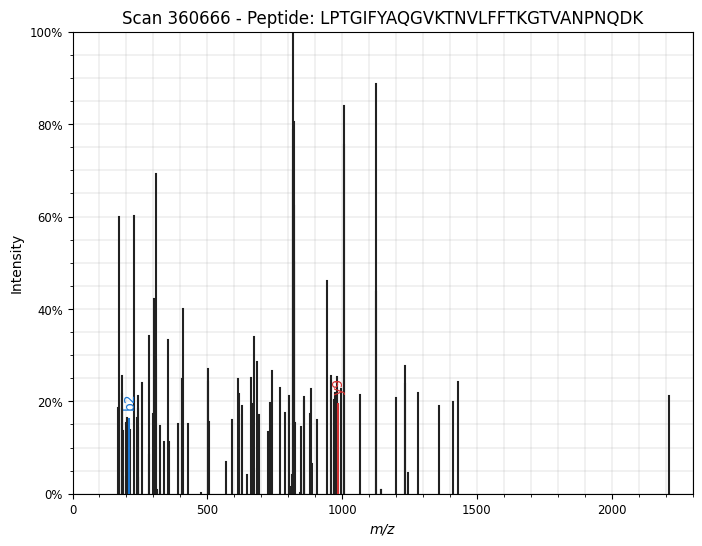

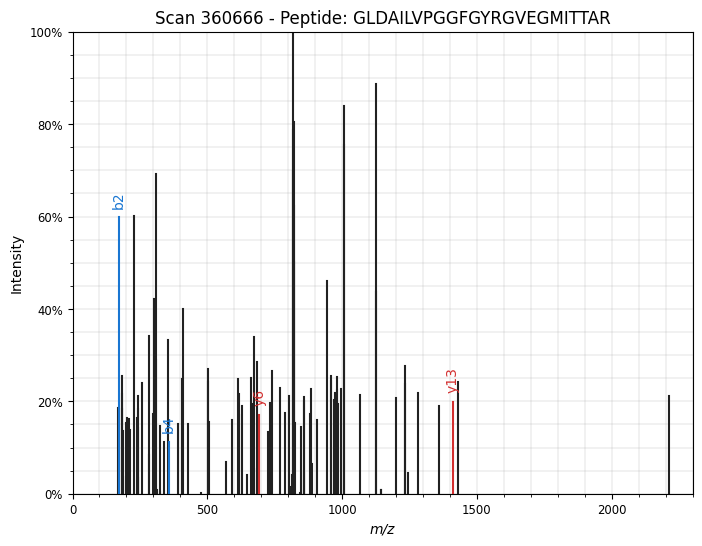

 88%|████████▊ | 4376/4969 [06:44<00:52, 11.30it/s]

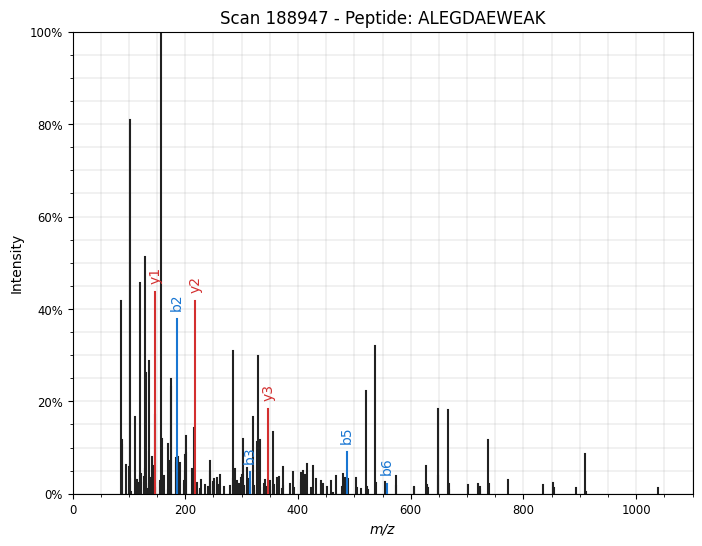

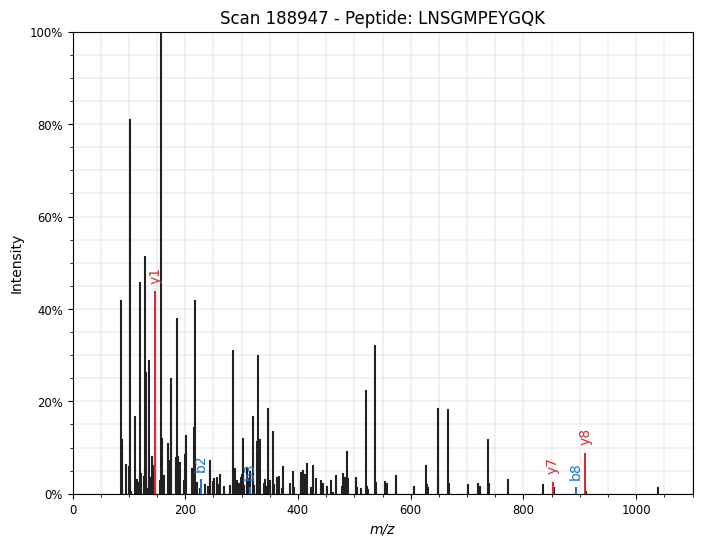

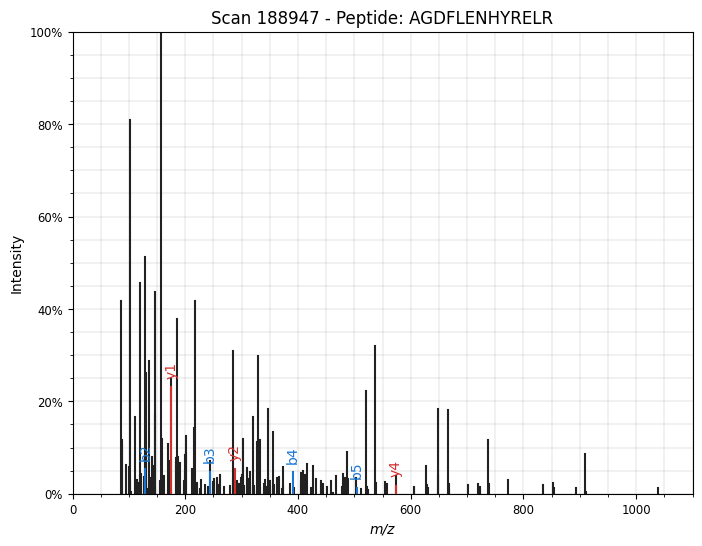

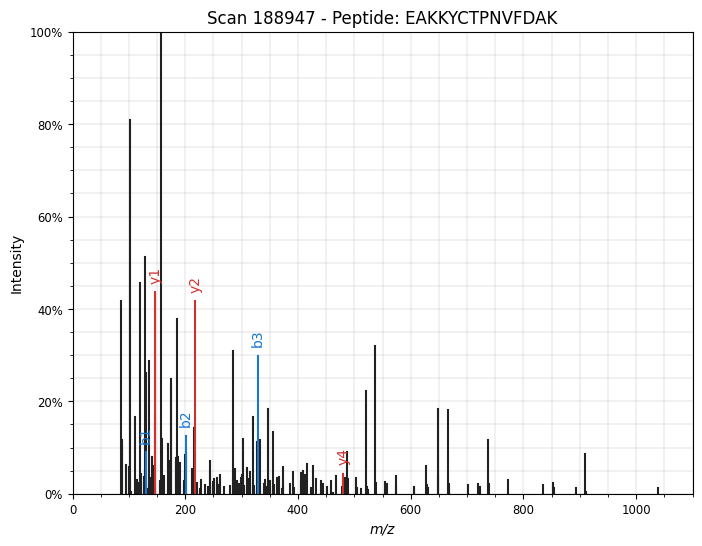

100%|██████████| 4969/4969 [07:37<00:00, 10.86it/s]


In [15]:
import pandas as pd
import spectrum_utils.spectrum as sus
import spectrum_utils.plot as sup
import matplotlib.pyplot as plt
from pyteomics import mgf
import random
from tqdm import tqdm

# File paths
file_path = "../mokapot.psms.txt"
mgf_file = "../LFQ_Orbitrap_AIF_Ecoli_01.mgf"

# Load mokapot output
df = pd.read_csv(file_path, sep="\t")

# Extract scan numbers correctly
df["ScanNr"] = df["SpecId"].apply(lambda x: x.split("|")[2].split("scan=")[1])

# Identify scan numbers that appear multiple times
duplicated_scans = df[df.duplicated(subset=["ScanNr"], keep=False)]

# Group by scan number
grouped_scans = duplicated_scans.groupby("ScanNr")

# Randomly sample a few scan numbers with multiple identifications
sampled_scans = random.sample(
    list(grouped_scans.groups.keys()), min(50000, len(grouped_scans))
)

# Load spectra from MGF file
spectra = list(mgf.read(mgf_file))

# Process and plot multiple peptides for each sampled scan
for scan_nr in tqdm(sampled_scans):
    scan_group = grouped_scans.get_group(scan_nr)  # Get all peptides for this scan

    # Find the spectrum in MGF file
    spectrum = None
    for spec in spectra:
        if (
            scan_nr in spec["params"]["title"].split("scan=")[1]
        ):  # Check scan number match
            spectrum = spec
            break

    if spectrum:
        # Convert to spectrum_utils format
        spec = sus.MsmsSpectrum(
            spectrum["params"]["title"],
            spectrum["params"]["pepmass"][0],  # Precursor mass
            2,  # Charge state (assumed default)
            spectrum["m/z array"],  # m/z values
            spectrum["intensity array"],  # Intensities
        )

        if scan_group.shape[0] < 4:
            continue
        # Plot each peptide annotation for the same spectrum
        for _, row in scan_group.iterrows():
            peptide_sequence = row["Peptide"]

            # Create a new spectrum instance for each peptide
            annotated_spec = sus.MsmsSpectrum(
                spec.identifier,
                spec.precursor_mz,
                spec.precursor_charge,
                spec.mz,
                spec.intensity,
            )

            # Annotate with different peptide sequences
            annotated_spec.annotate_proforma(
                peptide_sequence,
                fragment_tol_mass=20,
                fragment_tol_mode="ppm",
                ion_types="by", #"abcxyzImpr"
            )

            # Plot the spectrum with current peptide annotation
            plt.figure(figsize=(8, 6))
            sup.spectrum(annotated_spec)
            plt.title(f"Scan {scan_nr} - Peptide: {peptide_sequence}")
            plt.show()

    else:
        print(f"No spectrum found for scan {scan_nr}")

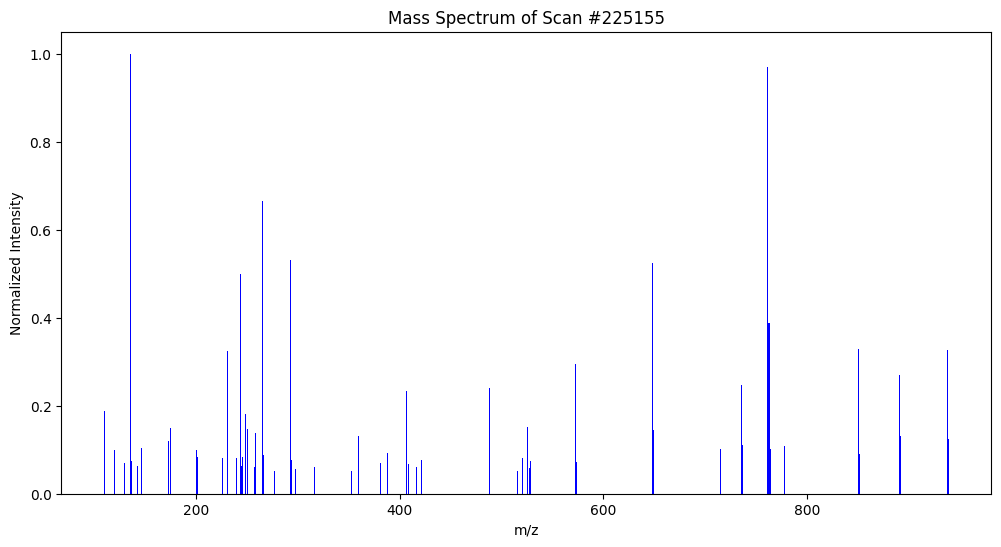

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
7
8
9
10
11
12
13
14
1

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyteomics import mass

# Define the spectrum data
spectrum_data = """
110.0717087	73661.23757
112.0874481	9250.368164
115.0867004	2637.896017
116.0702515	468.7027525
119.0495453	14243.94629
120.0721817	6080.785645
120.0810394	39016.85266
121.0845947	499.5976037
125.1075974	10583.98549
129.0656891	2718.747157
129.0925598	3767.635068
129.1024628	10794.6523
130.0864105	27343.5636
131.1183929	11332.1905
133.0427399	9941.483125
136.0758362	390278.8455
136.0860138	4262.25
137.0793457	28808.7444
141.0657806	6478.993794
143.0815125	24690.09766
143.1180573	672.7139419
147.0444336	11986.37891
147.0765076	3988.413389
147.1128998	40137.946
155.0812378	9321.882227
155.1176147	11082.50168
156.0770416	12219.43643
158.0926514	16862.66211
159.0762482	7451.155499
161.0915833	46.17403407
167.0933075	4068.010254
170.1368408	1056.504349
171.0767975	17876.26893
171.1128845	6949.332836
171.1495056	5175.629955
172.0871582	9077.756331
172.1057434	3693.154053
173.1287079	46968.07407
174.0547791	3551.353713
174.1319122	8764.834809
175.1191254	57884.03729
177.1017303	3253.54015
183.1126556	11547.07444
183.1491394	14874.95768
185.1646881	9687.261823
186.0905914	13094.2107
187.0709839	12491.40217
187.108902	9488.474211
187.1437836	591.5511686
190.3403778	3743.244385
191.1175385	6388.257551
197.1283569	2885.817396
198.126358	3622.303223
199.070343	9017.874023
200.1398468	2583.991831
201.0872803	9731.977539
201.1234894	38678.7268
202.0870819	32776.10156
203.0672913	7193.454832
204.1340485	204.9696317
205.1000977	3955.556396
211.1441803	8290.235395
212.1028137	5302.49158
213.0867462	8068.097814
213.1600494	7579.991556
213.9938202	3504.530029
214.15625	6373.942104
215.1393433	8015.706496
216.0978546	3704.224623
219.1130219	2616.699711
223.1566772	761.493683
226.1181641	4218.019943
226.1544189	31817.95705
227.101944	4304.425858
228.134613	5359.98305
229.1214752	3872.186279
230.1165466	7314.748535
231.1131897	126905.4375
232.1146698	16891.99628
235.0747528	14616.67578
240.0983276	31684.59128
240.134491	4705.986328
242.1502533	9235.088742
243.132843	5257.190049
244.0947113	4253.635236
244.140274	4360.385987
244.1655273	194977.756
244.193985	6088.140137
245.1678467	24731.24664
246.1311798	6792.08252
246.155304	32191.23366
247.1075287	4772.717575
249.1229095	71074.32813
249.1547089	7656.009277
250.1248016	7867.125
251.1022797	57087.64063
254.1155701	3161.75
255.0195618	7519.923768
257.1637573	3490.120361
258.1083374	23708.783
258.1400146	3860.906982
259.1087036	53464.92958
260.1119995	3233.837646
261.1243896	10287.8717
261.1563416	7566.109274
262.1391602	18897.11914
263.1451111	3851.007324
265.1184082	259694.7728
265.1510315	12912.07789
266.1226807	34617.07131
274.1213989	17407.82114
274.1876831	3699.903747
277.1181335	20262.17969
277.1522217	8076.247156
278.119751	3534.393799
284.0092468	4911.635397
285.1579285	822.1706068
286.1427307	7472.077067
288.2027283	13369.32908
290.0806885	10378.1127
293.1130676	207354.0998
294.1173401	30301.12125
296.1612549	4503.782715
296.1975403	604.6957179
298.1384583	21867.70117
308.162384	4912.620746
315.6858215	3774.808838
316.1499329	23985.08984
325.1889343	14918.35142
353.1812744	20376.6431
354.2214355	4815.421875
357.6922607	17140.19141
359.241333	51206.229
360.2440186	8616.591803
367.1939392	6780.382223
371.1950073	17386.10523
372.7009277	3622.543457
380.147522	8281.591019
381.2014465	26919.03449
388.1473389	36319.375
403.1633911	18463.55469
405.1733398	13614.60194
406.1941223	9336.468604
407.2293396	90962.43559
408.2312012	12701.15918
409.2081299	26270.34961
410.2071533	4113.982099
416.2594604	23945.28711
420.2393188	3035.776632
420.7424316	2588.554084
421.2254639	29986.3069
421.7243958	8129.593602
444.2348938	4885.119629
448.2244873	2465.305547
470.275238	6555.435059
474.2661743	2769.109029
479.9793396	5589.947754
487.2672424	3928.242676
488.21521	6580.091538
488.283905	93412.1875
489.2917786	18092.07862
492.2524414	171.1824662
496.9937744	2239.227724
500.2281189	3737.474121
503.2220154	8916.021484
503.7302246	10832.62427
507.2610779	5954.836914
507.9726257	11615.00586
515.3302002	19741.15124
516.2011108	18378.73047
520.3135376	31676.16514
521.3204956	5588.869629
525.2841187	59555.2523
525.7877808	22162.27653
526.2794189	14989.5625
527.3168335	23186.91406
528.303894	28676.88061
529.2336426	1264.705794
530.2432861	6227.013672
530.3215332	318.6074451
531.2696533	7658.369629
532.2824707	8548.375
538.7528687	16080.83493
539.2526245	14739.05176
555.262085	4746.578613
572.3521118	115079.75
573.3529663	28028.28125
583.2990723	5695.562565
587.3543701	1151.121737
599.3134766	4665.580566
617.3135376	5760.288574
629.2911987	7973.341797
631.3417969	13350.09863
632.3493042	8546.171408
638.3311157	2763.925283
643.2974243	11345.04395
648.3093262	204805.1549
648.845459	5213.152344
649.312439	56308.13015
650.3171997	14141.1123
651.3154297	2123.520181
658.3869019	4984.279865
685.3521729	12492.96484
686.3543091	5245.003216
694.333252	5092.559082
697.8687744	4636.928711
698.3891602	5501.577148
702.3228149	10030.03711
703.3378296	137.7401636
714.3790283	39602.46484
715.3898926	13303.53418
718.3826904	4513.988281
729.4252319	11577.67383
730.4209595	5812.449219
733.3640747	8249.073768
735.4175415	96317.29688
736.4180908	43045.75438
737.406189	10373.95898
741.3833618	5796.169922
742.381897	12940.50966
743.3813477	8078.21417
744.3769531	12088.06348
745.3879395	5597.886719
747.4130249	4683.161981
759.4078979	17793.71214
760.3828735	5689.673828
761.3983765	378841.4375
762.4024658	151055.0048
763.4026489	39549.10129
764.4067383	1239.020559
771.3734131	16264.61133
772.3594971	5020.487305
777.4137573	42403.93454
778.4195557	13634.61264
779.4165039	9729.600586
790.3808594	11730.40785
791.3764648	4856.471191
801.3966064	646.7462233
814.4089355	8823.649414
815.4129639	6194.243652
840.4528809	6416.713379
841.4431763	8008.791016
842.447876	5460.391113
843.4512939	4803.449707
846.4387817	468.14968
850.4430542	128745.0938
851.4393311	35622.93137
852.4457397	17817.41856
857.4786987	13693.04199
858.4807739	2588.757491
860.4692993	5953.703057
861.4330444	5189.683105
872.4331665	19396.609
873.4259644	12013.375
875.4546509	9808.302734
890.4419556	105428.2947
891.4439697	51598.38851
892.4371338	11234.2666
901.4364624	8767.617188
903.4598999	15179.11109
911.4036255	7318.735352
912.4101563	5182.955078
919.4613037	9817.331055
924.4702759	9025.851508
925.446228	4459.306641
937.4760132	127451.6563
938.4830322	48614.28516
939.4727783	18222.70368
947.458252	5937.396484
983.5005493	4427.340332
985.5097656	5179.413086
1023.519714	4782.898926
1054.513062	4025.74292
"""

# Convert to DataFrame
data = [list(map(float, line.split())) for line in spectrum_data.strip().split("\n")]
df = pd.DataFrame(data, columns=["m/z", "Intensity"])

# Normalize intensities
df["Normalized Intensity"] = df["Intensity"] / df["Intensity"].max()

# Filter peaks above a threshold (remove noise)
threshold = 0.05  # 5% of max intensity
df_filtered = df[df["Normalized Intensity"] > threshold]

# Plot the mass spectrum
plt.figure(figsize=(12, 6))
plt.bar(
    df_filtered["m/z"], df_filtered["Normalized Intensity"], width=1.0, color="blue"
)
plt.xlabel("m/z")
plt.ylabel("Normalized Intensity")
plt.title("Mass Spectrum of Scan #225155")
plt.show()

# Identify potential b- and y-ion peaks (differences in mass)
aa_masses = mass.std_aa_mass  # Standard amino acid masses
peptide_sequence = []

# Iterate through peaks and look for amino acid mass differences
for i in range(len(df_filtered) - 1):
    for j in range(i + 1, len(df_filtered)):
        print(j)
        mass_diff = abs(df_filtered.iloc[j]["m/z"] - df_filtered.iloc[i]["m/z"])

        # Match mass differences to amino acids
        closest_aa = min(aa_masses, key=lambda aa: abs(aa_masses[aa] - mass_diff))
        if abs(aa_masses[closest_aa] - mass_diff) < 0.01:  # Allow small error
            peptide_sequence.append(closest_aa)

# Get unique sequence order
unique_sequence = list(dict.fromkeys(peptide_sequence))

# Display results
print("".join(unique_sequence))

In [7]:
!pip install casanovo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 1.0 MB/s eta 0:00:00
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.2/69.2 kB 4.9 MB/s eta 0:00:00
  Using cached pycparser-2.22-py3-none-any.whl.metadata (943 bytes)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 11.0 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 763.0/763.0 kB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 766.7/766.7 MB 4.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 8.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 51.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 43.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 71.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━

In [9]:
!casanovo sequence -o results.mztab LFQ_Orbitrap_AIF_Ecoli_01.mgf

2025-02-10 13:45:29.916928: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-10 13:45:29.927660: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-10 13:45:29.930929: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-10 13:45:29.939688: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-10 13:45:30.5